<a href="https://colab.research.google.com/github/ChandanaLD/IWeb/blob/main/Identify_The_Dance_Form_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

In [ ]:
zip_path = '/content/drive/MyDrive/0664343c9a8f11ea.zip'
extract_path = '/content/dataset'

In [ ]:
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [ ]:
!pip install openpyxl scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
train_dir = '/content/dataset/dataset/train'
test_dir = '/content/dataset/dataset/test'
train_csv = pd.read_csv('/content/dataset/dataset/train.csv')
test_csv = pd.read_csv('/content/dataset/dataset/test.csv')
IMG_SIZE = (224, 224)

In [ ]:
train_csv['image_path'] = train_csv['Image'].apply(lambda x: os.path.join(train_dir, x))
test_csv['image_path'] = test_csv['Image'].apply(lambda x: os.path.join(test_dir, x))

In [ ]:
print(train_csv.head())

     Image         target                              image_path
0   96.jpg       manipuri   /content/dataset/dataset/train/96.jpg
1  163.jpg  bharatanatyam  /content/dataset/dataset/train/163.jpg
2  450.jpg         odissi  /content/dataset/dataset/train/450.jpg
3  219.jpg      kathakali  /content/dataset/dataset/train/219.jpg
4  455.jpg         odissi  /content/dataset/dataset/train/455.jpg


In [ ]:
le = LabelEncoder()
train_csv['label_encoded'] = le.fit_transform(train_csv['target'])

In [ ]:
missing_labels = train_csv[train_csv['label_encoded'].isnull()]
print(f"Missing label rows: {len(missing_labels)}")

Missing label rows: 0


In [ ]:
train_df, val_df = train_test_split(train_csv, test_size=0.2, stratify=train_csv['label_encoded'], random_state=42)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_csv['label_encoded']),
    y=train_csv['label_encoded']
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label_encoded',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label_encoded',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=test_csv,
    x_col='image_path',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 291 validated image filenames.
Found 73 validated image filenames.
Found 156 validated image filenames.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1113 - loss: 2.5835 - val_accuracy: 0.1233 - val_loss: 2.1356
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step - accuracy: 0.1468 - loss: 2.3729 - val_accuracy: 0.1370 - val_loss: 2.1018
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 602ms/step - accuracy: 0.1432 - loss: 2.2235 - val_accuracy: 0.1233 - val_loss: 2.1297
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - accuracy: 0.1179 - loss: 2.2092 - val_accuracy: 0.1233 - val_loss: 2.0933
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.2337 - loss: 2.1067 - val_accuracy: 0.1233 - val_loss: 2.1122
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step - accuracy: 0.0928 - loss: 2.1825 - val_accuracy: 0.1781 - val_loss: 2.0664
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.1499 - loss: 2.1288 - val_accuracy: 0.1370 - val_loss: 2.0646
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - accuracy: 0.1108 - loss: 2.1107 - val_accuracy: 0.20

In [ ]:
loss, acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2053 - loss: 2.0465 
✅ Validation Accuracy: 0.1918, Loss: 2.0596


In [ ]:
preds = model.predict(test_gen)
pred_classes = np.argmax(preds, axis=1)
decoded_preds = le.inverse_transform(pred_classes)

156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


In [ ]:
import numpy as np

pred_classes = np.argmax(preds, axis=1)
decoded_preds = le.inverse_transform(pred_classes)
predicted_probabilities = preds

for i in range(10):
    print(f"Predicted Label: {decoded_preds[i]}")
    print("Predicted Probabilities for each class:")
    for j, prob in enumerate(predicted_probabilities[i]):
        print(f"  Class {le.classes_[j]}: {prob:.4f}")
    print("-" * 40)

Predicted Label: bharatanatyam
Predicted Probabilities for each class:
  Class bharatanatyam: 0.1622
  Class kathak: 0.1311
  Class kathakali: 0.1032
  Class kuchipudi: 0.1317
  Class manipuri: 0.0997
  Class mohiniyattam: 0.1232
  Class odissi: 0.1281
  Class sattriya: 0.1207
----------------------------------------
Predicted Label: kathakali
Predicted Probabilities for each class:
  Class bharatanatyam: 0.1268
  Class kathak: 0.0979
  Class kathakali: 0.1708
  Class kuchipudi: 0.1068
  Class manipuri: 0.1344
  Class mohiniyattam: 0.1509
  Class odissi: 0.0870
  Class sattriya: 0.1254
----------------------------------------
Predicted Label: kathakali
Predicted Probabilities for each class:
  Class bharatanatyam: 0.1306
  Class kathak: 0.0926
  Class kathakali: 0.1741
  Class kuchipudi: 0.1051
  Class manipuri: 0.1335
  Class mohiniyattam: 0.1585
  Class odissi: 0.0828
  Class sattriya: 0.1228
----------------------------------------
Predicted Label: bharatanatyam
Predicted Probabilit

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Murugashankari_Leo.jpg/640px-Murugashankari_Leo.jpg"
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
if response.status_code == 200 and "image" in response.headers.get("Content-Type", ""):
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((224, 224))

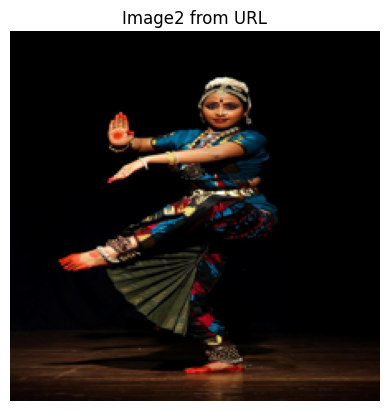

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title("Image2 from URL")
plt.show()

In [ ]:
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction[0])
predicted_class = le.inverse_transform([predicted_index])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [ ]:
print(f"Predicted Class: {predicted_class}")

Predicted Class: bharatanatyam


In [ ]:
url = "https://www.robinage.com/wp-content/uploads/2022/09/Kathakali-800x534.jpg"
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
if response.status_code == 200 and "image" in response.headers.get("Content-Type", ""):
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((224, 224))

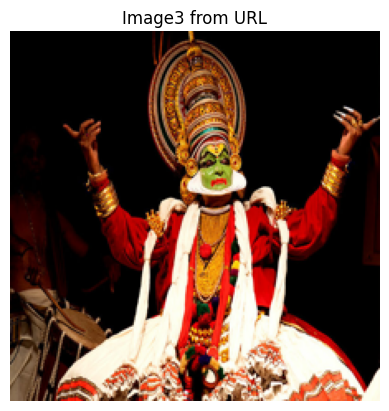

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title("Image3 from URL")
plt.show()

In [ ]:
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction[0])
predicted_class = le.inverse_transform([predicted_index])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [ ]:
print(f"Predicted Class: {predicted_class}")

Predicted Class: kathakali
